# Modeling Food Serving Sizes Through Nutrition Profiles

### Notebook 3 - Modeling

## Table of Contents

1. [Importing Packages](#Importing-Packages)
2. [Reading Data](#Reading-Data)
3. [Feature Engineering](#Feature-Engineering)
4. [Preprocessing](#Preprocessing)
5. [Modeling](#Modeling)
    1. [Baseline Model](#Baseline-Model)
    2. [Linear Regression](#Linear-Regression)
    3. [Ridge Regression](#Ridge-Regression)
    4. [LASSO Regression](#LASSO-Regression)
    5. [Feed Forward Neural Network](#Feed-Forward-Neural-Network)
6. [Model Evaluations](#Model-Evaluations)
    1. [R<sup>2</sup> Score](#R2-Score)
    2. [Mean Squared Error](#Mean-Squared-Error)
    3. [Visualizations](#Visualizations)
7. [Conclusions and Recommendations](#Conclusions-and-Recommendations)
    1. [Conclusions](#Conclusions)
    2. [Recommendations](#Recommendations)

## Importing Packages

In [1]:
# general tools/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import set_random_seed
import pickle

# imports for NLP
import regex as re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# imports for modeling
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, SGDRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

# making the magic happen for plots
%matplotlib inline

# setting options for better viewing
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 50)

# setting global random seeds for numpy and tensorflow
np.random.seed(42)
set_random_seed(777)

Using TensorFlow backend.


## Reading Data

In [2]:
foods = pd.read_csv("../datasets/clean_foods_df.csv")

In [3]:
foods.head()

,fdc_id,brand_owner,branded_food_category,description,ingredients,serving_size,household_serving_fulltext,energy,fat_total,fat_sat,fat_trans,chol,protein,carbs,fiber,sugars,sodium
0,356425,"G. T. Japan, Inc.",Ice Cream & Frozen Yogurt,MOCHI ICE CREAM BONBONS,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",40.0,1 PIECE,200.0,6.25,3.75,0.0,25.0,2.5,35.00,0.0,30.00,75.0
1,356426,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",CHIPOTLE BARBECUE SAUCE,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",37.0,2 Tbsp,162.0,0.00,0.00,0.0,0.0,0.0,43.24,0.0,37.84,703.0
2,356427,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",HOT & SPICY BARBECUE SAUCE,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",34.0,2 Tbsp,176.0,0.00,0.00,0.0,0.0,0.0,41.18,0.0,35.29,676.0
3,356428,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",35.0,2 Tbsp,143.0,0.00,0.00,0.0,0.0,0.0,34.29,0.0,28.57,971.0
4,356429,FRESH & EASY,"Ketchup, Mustard, BBQ & Cheese Sauce",BARBECUE SAUCE,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",37.0,2 Tbsp,189.0,0.00,0.00,0.0,0.0,0.0,45.95,0.0,43.24,757.0


## Feature Engineering

Before the modeling process begins, we need to fully prepare the dataset. In the previous notebook we had seen the tailed distribution of the serving size target, so we will make a new column here to use as the target for modeling.

In [4]:
foods["log_serv"] = np.log(foods["serving_size"])

Since we want to use the category of the food product as a feature, we will have to turn them into dummy columns first.

In [5]:
foods = pd.get_dummies(data=foods,
                       columns=["branded_food_category"],
                       prefix="cat",
                       drop_first=True)

In [6]:
# checking for new cols
foods.head()

,fdc_id,brand_owner,description,ingredients,serving_size,household_serving_fulltext,energy,fat_total,fat_sat,fat_trans,chol,protein,carbs,fiber,sugars,sodium,log_serv,cat_All Noodles,"cat_Bacon, Sausages & Ribs",cat_Baking,cat_Baking Accessories,cat_Baking Additives & Extracts,cat_Baking Decorations & Dessert Toppings,cat_Baking/Cooking Mixes (Perishable),cat_Baking/Cooking Mixes (Shelf Stable),cat_Baking/Cooking Mixes/Supplies Variety Packs,cat_Baking/Cooking Supplies (Shelf Stable),cat_Beef - Prepared/Processed,cat_Biscuits/Cookies (Shelf Stable),cat_Bread & Muffin Mixes,cat_Breads & Buns,cat_Breakfast Drinks,cat_Breakfast Foods,"cat_Breakfast Sandwiches, Biscuits & Meals",cat_Butter & Spread,"cat_Cake, Cookie & Cupcake Mixes",cat_Cakes - Sweet (Frozen),cat_Cakes - Sweet (Shelf Stable),"cat_Cakes, Cupcakes, Snack Cakes",cat_Candy,cat_Canned & Bottled Beans,cat_Canned Condensed Soup,cat_Canned Fruit,cat_Canned Meat,cat_Canned Seafood,cat_Canned Soup,cat_Canned Tuna,cat_Canned Vegetables,cat_Cereal,cat_Cereal/Muesli Bars,...,"cat_Pancakes, Waffles, French Toast & Crepes",cat_Pasta Dinners,cat_Pasta by Shape & Type,cat_Pasta/Noodles - Not Ready to Eat (Frozen),cat_Pastry Shells & Fillings,"cat_Pepperoni, Salami & Cold Cuts","cat_Pickles, Olives, Peppers & Relishes",cat_Pies/Pastries - Sweet (Shelf Stable),cat_Pies/Pastries/Pizzas/Quiches - Savoury (Frozen),cat_Pizza,cat_Pizza Mixes & Other Dry Dinners,cat_Plant Based Milk,cat_Plant Based Water,cat_Popcorn (Shelf Stable),"cat_Popcorn, Peanuts, Seeds & Related Snacks",cat_Pork Sausages - Prepared/Processed,"cat_Poultry, Chicken & Turkey",cat_Powdered Drinks,cat_Pre-Packaged Fruit & Vegetables,cat_Prepared Pasta & Pizza Sauces,cat_Prepared Subs & Sandwiches,cat_Prepared Wraps and Burittos,cat_Processed Cheese & Cheese Novelties,cat_Puddings & Custards,cat_Rice,cat_Salad Dressing & Mayonnaise,"cat_Sausages, Hotdogs & Brats","cat_Seasoning Mixes, Salts, Marinades & Tenderizers","cat_Snack, Energy & Granola Bars",cat_Soda,cat_Soups - Prepared (Shelf Stable),cat_Specialty Formula Supplements,cat_Sport Drinks,cat_Stuffing,cat_Sushi,cat_Syrups & Molasses,cat_Tea Bags,cat_Tomatoes,cat_Vegetable & Cooking Oils,cat_Vegetable Based Products / Meals - Not Ready to Eat (Frozen),cat_Vegetable and Lentil Mixes,cat_Vegetables - Prepared/Processed (Frozen),cat_Vegetables - Prepared/Processed (Shelf Stable),cat_Vegetarian Frozen Meats,cat_Vitamins,cat_Water,cat_Weight Control,cat_Wholesome Snacks,cat_Yogurt,cat_Yogurt/Yogurt Substitutes (Perishable)
0,356425,"G. T. Japan, Inc.",MOCHI ICE CREAM BONBONS,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",40.0,1 PIECE,200.0,6.25,3.75,0.0,25.0,2.5,35.00,0.0,30.00,75.0,3.688879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,356426,FRESH & EASY,CHIPOTLE BARBECUE SAUCE,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",37.0,2 Tbsp,162.0,0.00,0.00,0.0,0.0,0.0,43.24,0.0,37.84,703.0,3.610918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,356427,FRESH & EASY,HOT & SPICY BARBECUE SAUCE,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",34.0,2 Tbsp,176.0,0.00,0.00,0.0,0.0,0.0,41.18,0.0,35.29,676.0,3.526361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,356428,FRESH & EASY,BARBECUE SAUCE,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",35.0,2 Tbsp,143.0,0.00,0.00,0.0,0.0,0.0,34.29,0.0,28.57,971.0,3.555348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,356429,FRESH & EASY,BARBECUE SAUCE,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",37.0,2 Tbsp,189.0,0.00,0.00,0

## Preprocessing

Our preprocessing steps here are to split our dataset into the X features and y target, and then scale the features so they can be flexibly used across different model types.

The predicting features are going to include the full nutritional profile (minus the serving size), and the branded food category.

We do not need the ID column since it should not be indicative of the food or serving size.

The brand owner could potentially have an impact on serving size, as certain companies may tend to have larger or smaller serving sizes in general, though with over 24,000 different brand owners, utilizing this as a modeling feature will have to be set aside for the scope of this current project.

The description column is most likely not going to help, as simple prducts such as beans or vegetables will probably have very similar descriptions, and as the foods get more complicated, the descriptions will begin to vary more and more. Again, there are over 160,000 different food descriptions, so it would be difficult to use this as a modeling feature.

The ingredients columnshows the highest promise for being useful in the modeling process, but due to time and computing restrictions, it is not going to be used at this time.

The household serving size, as with the description column, can vary so much between foods, and are not necessarily standardized, so its usefulness is most likely quite low.

The final two columns to be dropped are the serving size and logged serving size, which are the targets, so they should not be part of the training data.

In [7]:
# setting X and y vars
X = foods.drop(columns=["fdc_id", 
                        "brand_owner", 
                        "description", 
                        "ingredients", 
                        "household_serving_fulltext",
                        "serving_size",
                       "log_serv"])
y = foods["log_serv"]

In [8]:
# splitting data to train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# instantiating scaler
ss = StandardScaler()

# scaling X data
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

Now that the data has been fully prepared, we can begin the modeling process.

## Modeling

### Baseline Model

There is a way of predicting serving size without using any machine learning, by simply using the mean of the target. For this model, we will measure the MSE, and will use the default scoring of R<sup>2</sup> for the remainder of the models. Both metrics will be evaluated for all models after the modeling is complete.

In [9]:
# building a base model to compare results against
# using code from Boom's Local Session

# Instantiate: creates a dummy regression that always predicts the mean of the target
base_mean = DummyRegressor(strategy='mean')

# Fit the "model"
base_mean_model = base_mean.fit(X_train, y_train)

# Get predictions for our testing set (not kaggle testing set)
y_hat_base_train = base_mean.predict(X_train)
y_hat_base_test = base_mean.predict(X_test)

# Get R2
print("Our Train MSE Score for our Base Model is:", metrics.mean_squared_error(np.exp(y_train),np.exp(y_hat_base_train)))
print("Our Test MSE Score for our Base Model is:",  metrics.mean_squared_error(np.exp(y_test),np.exp(y_hat_base_test)))

Our Train MSE Score for our Base Model is: 3685.336822662155
Our Test MSE Score for our Base Model is: 3833.116046199187


### GridSearch Function

The help find the best possible model parameters, we should build a function to perform gridsearches for us. We can then implement this function on any model type and set of parameters to optimize each one.

In [10]:
# bringing in func from Reddit NLP project
def grid_searcher(pipe, params):
    gs = GridSearchCV(estimator=pipe, param_grid=params, cv=3, verbose=1, n_jobs=3)
    gs.fit(X_train_sc, y_train)
    print(f'CrossVal Score: {gs.best_score_}')
    print(f'Training Score: {gs.score(X_train_sc, y_train)}')
    print(f'Testing Score: {gs.score(X_test_sc, y_test)}')
    print(gs.best_params_)
    return gs

### Linear Regression

We will start our search for the best model with a simple OLS, or ordinary least squares model. As linear regression is a very simple model, there is really no hyperparameter searching that needs to be performed. 

In [11]:
linreg = LinearRegression()
linreg_model = linreg.fit(X_train, y_train)

In [12]:
print(f"The train R2 score is: {linreg_model.score(X_train, y_train)}.")
print(f"The test R2 score is: {linreg_model.score(X_test, y_test)}.")

The train R2 score is: 0.7353463856717573.
The test R2 score is: 0.7406407151042635.


This basic linear regression model is not scoring very high, although it is also showing a fairly low variance. Since we did see some multicolinearity in a few of the features during the EDA, it may be worth looking at a LASSO or ridge regression for some improvements.

### Ridge Regression

While There is also a `RidgeCV` model that will test different alpha values and cross-validate, it only tests three values, which may not truly be optimizing that hyperparameter. We will employ the custom gridsearching function to expand on these values, and be able to hone in on a more precise alpha value.

In [13]:
# making pipeline for ridge model
ridge_pipe = Pipeline([("ridge", Ridge())])

ridge_params = {
    "ridge__alpha": [11, 12, 13]
}

In [14]:
ridge_model = grid_searcher(ridge_pipe, ridge_params)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   11.0s finished


CrossVal Score: 0.7338202830606281
Training Score: 0.7353441884095184
Testing Score: 0.7406257916854004
{'ridge__alpha': 12}


### LASSO Regression

As the `LassoCV` model already iterates through a list of 100 alphas, we do not need to run the gridsearching function on it. 

In [15]:
lasso = LassoCV()
lasso_model = lasso.fit(X_train_sc, y_train)

/Users/jondov/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [16]:
train_r2 = lasso_model.score(X_train_sc, y_train)
test_r2 = lasso_model.score(X_test_sc, y_test)

print(f"The train R2 score is: {train_r2}.")
print(f"The test R2 score is: {test_r2}.")

The train R2 score is: 0.7351460362337019.
The test R2 score is: 0.7403776480182412.


Neither of these regularization methods had any large impact on the R<sup>2</sup> scores. These model are typically most helpful to regularize overfit linear regressions, and as our initial model was not very overfit, they may not just not be enough of an improvement. We may need to utilize a more advanced regression method.

### Feed Forward Neural Network

As using a Feed Forward Neural Network was showing promise as the best model type to use, we should have a way of effectively optimizing it. While a Keras Sequential model cannot be passed through Scikit-learn's `GridSearchCV`, we can make our own custom function to essentially perform the same type of task. To that end, the following functions were created, which were adapted from code written by Mahdi Shadkam-Farrokhi.

The first function to be made is for establishing the permutations of parameters. This fucntion will take in a dictionary of all the layer parameters, and unpacks each combination into a distinct set of single parameters that a model can be built on.

In [17]:
def permutate_params(grid_params):
    # returns a list of all combinations of unique parameters from the given dictionary
    out = [{}]
    for param_name, param_list in grid_params.items():
        if len(param_list) == 1:
            for item in out:
                item[param_name] = param_list[0]
        else:
            temp_out = []
            for param_val in param_list:
                for item in out:
                    cloned_item = item.copy()
                    cloned_item[param_name] = param_val
                    temp_out.append(cloned_item)
            out = temp_out
    return out

The next piece is to take a dictionary of parameters and build a functioning model out of it. We will make a model building fucntion to perfrom this action. It will take our train/test split data, and a dictionary of the parameters that has the specified keys. The function will reach into each of the keys for the appropriate attribute, and then apply that to the corresponding layer. To increase flexibility, there will be default settings for each of the parameters, so that the dictioanry does not have to contain entries for everything.

In [18]:
def build_model(params_dict, X_train, X_test, y_train, y_test):
    # defining params
    first_layer_nodes = params_dict.get("first_layer_nodes") or 16            # default low nodes
    first_dropout_rate = params_dict.get("first_dropout_rate") or 0.0         # default no dropout
    
    second_layer_nodes = params_dict.get("second_layer_nodes") or 16          # default low nodes
    second_dropout_rate = params_dict.get("second_dropout_rate") or 0.0       # default no dropout
    
    third_layer_nodes = params_dict.get("third_layer_nodes") or 16            # default low nodes
    third_dropout_rate = params_dict.get("third_dropout_rate") or 0.0         # default no dropout  
    
    reg = params_dict.get("reg") or 0                                         # default no reg
    
    epochs = params_dict.get("epochs") or 10                                  # default low epochs
    batch_size = params_dict.get("batch_size") or 1024                        # default large batch
    early_stop = params_dict.get("early_stop") or EarlyStopping(monitor="val_loss",
                                                                min_delta=0.000000001,  # small delta
                                                                patience=100)           # large patience
    
    # instantiating model
    model = Sequential()

    # adding layers according to inputs
    # first layer(s)
    model.add(Dense(first_layer_nodes,
                   activation="relu",
                   input_shape=(X_train.shape[1],),
                   kernel_regularizer=regularizers.l2(reg)))
    model.add(Dropout(first_dropout_rate))
    
    # second layer(s)
    model.add(Dense(second_layer_nodes,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(reg)))
    model.add(Dropout(second_dropout_rate))
    
    # third layer(s)
    model.add(Dense(third_layer_nodes,
                    activation="relu",
                    kernel_regularizer=regularizers.l2(reg)))
    model.add(Dropout(third_dropout_rate))
    
    # output layer
    model.add(Dense(1))
    
    # compiling model
    model.compile(loss="mean_squared_error",
             optimizer="adam")
    
    # fitting model according to inputs
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                       callbacks=[early_stop])
    return model, history

The final piece is to combine the two above functions into one function that will take and X and y, along with the parameter dictionary, and do the rest of the work for us. This function performs a train/test split, scales the data, and the runs the data through each of the models within the parameter dictionary. Each iteration will check the determined metric, and updates it if it has been improved. At the end of the function, the model that gave the best score for the metric is returned.

In [19]:
def nn_grid_search(
    X,
    y,
    grid_params,
    random_state=42
):
    ### this will make a series of FFNN models 
    ### and return the one with the best score as set below
    ### currently set to test r2 score
    
    # list of all parameter combinations
    all_params = permutate_params(grid_params)
    
    # creating vars with to update each iter
    best_model = None
    best_score = 0.0 
    best_params = None
    best_history = None
    
    # train/test split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    # scaling data
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    # looping through the unpacked parameter list
    for i, params in enumerate(all_params):
        
        # keeping track of which model we're running
        print(f"Building model {i + 1} of {len(all_params)}")
        
        # bulding the model
        model, history = build_model(
            params_dict = params,
            X_train = X_train_sc, 
            X_test = X_test_sc, 
            y_train = y_train, 
            y_test = y_test
        )
        
        # making preds and scoring
        test_preds = model.predict(X_test_sc)
        score = metrics.r2_score(y_test, test_preds)
        
        # checking if the score beats the current best
        # updates vars if true
        if score > best_score:
            print("***Good R2 found: {:.2%}***".format(score))
            best_score = score
            best_model = model
            best_params = params
            best_history = history
    
    # loop is done, return the best model
    return {
        "best_model"   : best_model,
        "best_score"   : best_score,
        "best_params"  : best_params,
        "best_history" : best_history,
        "test_preds"   : test_preds
    }

Now that we have our functions built, we can run the search. We will start with finding the best number of nodes out of three hidden layers.

In [20]:
###     DO NOT RUN     ###
###   W/O NEW PARAMS   ###

# # setting params
# node_params = {
#     "first_layer_nodes": [256, 128, 64],
#     "second_layer_nodes": [128, 64, 32],
#     "third_layer_nodes": [64, 32, 16],
# }

In [21]:
###   DO NOT RE-RUN    ###
###   W/O NEW PARAMS   ###

# best_model_dict = nn_grid_search(X, y, node_params)

After the grid search has completed, we have a list of dictionaries that holds the model that gave use the highest R<sup>2</sup> score, along with the parameters of that model, the score, and the history.

In order to not have to run this cell multiple times, but be able to keep the model object, we are going to pickle the result. This process will store the completed model as its specific byte stream, which can then be loaded back exactly as it was, without needing to fit each of the models over again.

In [22]:
###   DO NOT RE-RUN    ###
###   W/O ABOVE CELL   ###

# # pickling tutorial found on https://www.datacamp.com/community/tutorials/pickle-python-tutorial

# # making new file
# outfile = open("nn_gs_pickle", "wb")

# # dumping model to pickle
# pickle.dump(best_model_dict, outfile)

# # closing new file
# outfile.close()

In [23]:
# opening pickle file
infile = open("nn_gs_pickle", "rb")

# unpickling back into model object
best_model_dict = pickle.load(infile)

infile.close()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [24]:
best_model_dict

{'best_model': <keras.engine.sequential.Sequential at 0x1a35d9c3d0>,
 'best_score': 0.8712777377952519,
 'best_params': {'first_layer_nodes': 256,
  'second_layer_nodes': 128,
  'third_layer_nodes': 64},
 'best_history': <keras.callbacks.History at 0x1a36ba2b10>,
 'test_preds': array([[5.497277 ],
        [4.41725  ],
        [3.7483513],
        ...,
        [5.102507 ],
        [4.7589536],
        [3.4706845]], dtype=float32)}

In [25]:
# making predictions
nn_train_preds = best_model_dict["best_model"].predict(X_train_sc)
nn_test_preds = best_model_dict["best_model"].predict(X_test_sc)

print(f"The train R2 score is: {metrics.r2_score(y_train, nn_train_preds)}.")
print(f"The test R2 score is: {metrics.r2_score(y_test, nn_test_preds)}.")

The train R2 score is: 0.8742272462040366.
The test R2 score is: 0.8712777377952519.


We can now take the model that had the best promise, and use those parameters in a new model to find the best amount of epochs for it. After some trials, 75 epochs seemed to be the best number to use, though we were left with some slight overfitting, so an additional search will be performed on using different regularization techniques.

In [26]:
# pulling up best params
best_model_dict["best_params"]

{'first_layer_nodes': 256, 'second_layer_nodes': 128, 'third_layer_nodes': 64}

In [27]:
###     DO NOT RUN     ###
###   W/O NEW PARAMS   ###

# # making new param dict with regularization
# pdict = {
#     "first_layer_nodes": [256],
#     "first_dropout_rate": [0, 0.5],
#     "second_layer_nodes": [128],
#     "second_dropout_rate": [0, 0.5],
#     "third_layer_nodes": [64],
#     "third_dropout_rate": [0, 0.5],
#     "reg": [0.001, 0.01],
#     "epochs": [75],
#     "early_stop": [EarlyStopping(monitor="val_loss",
#                                 min_delta=0.0001,
#                                 patience=7)]         
# }

In [28]:
###   DO NOT RE-RUN    ###
###   W/O NEW PARAMS   ###

# final_nn_model_dict = nn_grid_search(X, y, grid_params=pdict)

Now that the grid search has completed, we want to once again pickle the resulting model so we don't have to run the cell multiple times.

In [29]:
###   DO NOT RE-RUN    ###
###   W/O ABOVE CELL   ###

# # making new file
# outfile = open("final_nn_pickle", "wb")

# # dumping model to pickle
# pickle.dump(final_nn_model_dict, outfile)

# # closing new file
# outfile.close()

In [30]:
# opening pickle file
infile = open("final_nn_pickle", "rb")

# unpickling back into model object
final_nn_model_dict = pickle.load(infile)

infile.close()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
final_nn_model_dict

{'best_model': <keras.engine.sequential.Sequential at 0x1a3508fe90>,
 'best_score': 0.8979889947307514,
 'best_params': {'first_layer_nodes': 256,
  'first_dropout_rate': 0,
  'second_layer_nodes': 128,
  'second_dropout_rate': 0,
  'third_layer_nodes': 64,
  'third_dropout_rate': 0,
  'reg': 0.001,
  'epochs': 75,
  'early_stop': <keras.callbacks.EarlyStopping at 0x1a38fc5ad0>},
 'best_history': <keras.callbacks.History at 0x1a3b0a2f90>,
 'test_preds': array([[5.361496 ],
        [4.5653467],
        [3.9581513],
        ...,
        [4.8386326],
        [4.725911 ],
        [3.547521 ]], dtype=float32)}

In [32]:
# saving final model as it's own object
final_nn_model = final_nn_model_dict["best_model"]

# making predictions
nn_train_preds = final_nn_model.predict(X_train_sc)
nn_test_preds = final_nn_model.predict(X_test_sc)

# checking r2
print(f"The train R2 score is: {metrics.r2_score(y_train, nn_train_preds)}.")
print(f"The test R2 score is: {metrics.r2_score(y_test, nn_test_preds)}.")

The train R2 score is: 0.9023666954449441.
The test R2 score is: 0.8979889947307514.


This appears to have given use the best scores out of all the models. Before making any conclusions, though, we are going to compile all of the results and see the metrics together to make the final call.

## Model Evaluations

To help automate the eavluations process, we are going to compile the train and test predictions for each of our models, and from there we will be able to easily evaluate the desired metrics from one spot.

In [81]:
# making train pred df
train_pred_df = pd.DataFrame(columns=["y_train",
                                      "base",
                                      "linear",
                                      "ridge",
                                      "lasso",
                                      "neural_net"])

# making test pred df
test_pred_df = pd.DataFrame(columns=["y_test",
                                     "base",
                                     "linear",
                                     "ridge",
                                     "lasso",
                                     "neural_net"])
# filling both y_true cols
train_pred_df["y_train"] = np.exp(y_train)
test_pred_df["y_test"] = np.exp(y_test)

In [82]:
# making dicts of our models
# one for unscaled Xs
unsc_models = {"base": base_mean_model,
               "linear": linreg_model}

# one for scaled Xs
sc_models = {"ridge": ridge_model,
             "lasso": lasso_model,
             "neural_net": final_nn_model}


# looping through unsc_models to input preds into df
for model in unsc_models.keys():
    train_pred_df[model] = np.exp(unsc_models[model].predict(X_train))
    test_pred_df[model] = np.exp(unsc_models[model].predict(X_test))

# looping through sc_models to input preds into df
for model in sc_models.keys():
    train_pred_df[model] = np.exp(sc_models[model].predict(X_train_sc))
    test_pred_df[model] = np.exp(sc_models[model].predict(X_test_sc))

In [83]:
train_pred_df.head()

,y_train,base,linear,ridge,lasso,neural_net
147647,56.0,43.234931,44.004832,44.003356,40.832121,26.068771
109815,52.0,43.234931,53.521408,53.525497,53.234836,51.870228
141021,28.0,43.234931,26.400813,26.402932,26.655251,30.008564
110050,60.0,43.234931,60.934555,60.906349,60.084064,46.401402
163510,247.0,43.234931,175.687923,175.667826,174.521025,257.309235


In [84]:
test_pred_df.head()

,y_test,base,linear,ridge,lasso,neural_net
88488,245.0,43.234931,133.968872,133.919194,133.823287,291.741333
179653,91.0,43.234931,93.642083,93.628761,93.202277,90.791046
169634,45.0,43.234931,46.437591,46.437398,46.216515,47.342304
45499,21.0,43.234931,25.529767,25.542199,25.716819,25.163540
113786,25.0,43.234931,25.680915,25.691698,25.799408,27.399517


### R<sup>2</sup> Score

We can evaluate the R<sup>2</sup> scores to determine how much of the variation in the serving sizes can be explained by our models.

In [85]:
# making r2 dataframe
r2_df = pd.DataFrame(index=train_pred_df.columns[1:], columns=["train_r2", "test_r2"])

# looping through models
for model in train_pred_df.columns[1:]:
    
    # setting the scores for the model row
    r2_df.loc[model] = [
        round(100 * metrics.r2_score(train_pred_df["y_train"], train_pred_df[model]), 2),
        round(100 * metrics.r2_score(test_pred_df["y_test"], test_pred_df[model]), 2)
    ]
    
# making variance column
r2_df["var"] = abs(r2_df["train_r2"] - r2_df["test_r2"])

In [86]:
# pulling up final df
r2_df

,train_r2,test_r2,var
base,-12.78,-13.27,0.49
linear,69.2,68.48,0.72
ridge,69.2,68.48,0.72
lasso,69.19,68.44,0.75
neural_net,81.78,80.31,1.47


We can see in this dataframe why the MSE was used as the scoring method for the original baseline model. Due to the intricacies of this regression problem, and the large amount of features being used, the mean prediction results in a negative score here. In other words, using the mean serving size is a very bad predictor. Since we translated our predictions from the logged-serving size back to the real serving size, we appear to have dropped our scores a bit. This is unfortunate, but not completely unexpected, as exponentiating the numbers puts them on a much larger scale, so the errors are going to be magnified. However, the FFNN has maintained its leading score.

### Mean Squared Error

The mean squared error can sometimes be a better scoring method than R<sup>2</sup>, since it is a direct measure of how far off the predictions are from the true y-values. Since we previously saw the MSE from the base model, we should compare that with our improved model types as well.

In [87]:
# making r2 dataframe
mse_df = pd.DataFrame(index=train_pred_df.columns[1:], columns=["train_mse", "test_mse"])

# looping through models
for model in train_pred_df.columns[1:]:
    
    # setting the scores for the model row
    mse_df.loc[model] = [
        metrics.mean_squared_error(train_pred_df["y_train"], train_pred_df[model]),
        metrics.mean_squared_error(test_pred_df["y_test"], test_pred_df[model])
    ]

# making variance column
mse_df["var"] = abs(mse_df["train_mse"] - mse_df["test_mse"])

In [88]:
# pulling up final df
mse_df

,train_mse,test_mse,var
base,3685.34,3833.12,147.779
linear,1006.6,1066.49,59.8882
ridge,1006.64,1066.57,59.9296
lasso,1006.72,1067.95,61.2309
neural_net,595.368,666.202,70.8335


We can see from these numbers that the neural network had by far the lowest MSE scores, though it was somewhat more overfit than the others , showing the highest variance number (excluding the baseline "model"). However, due to how much better of a performance it was able to give us, we are going to select that as our final model.

### Visualizations

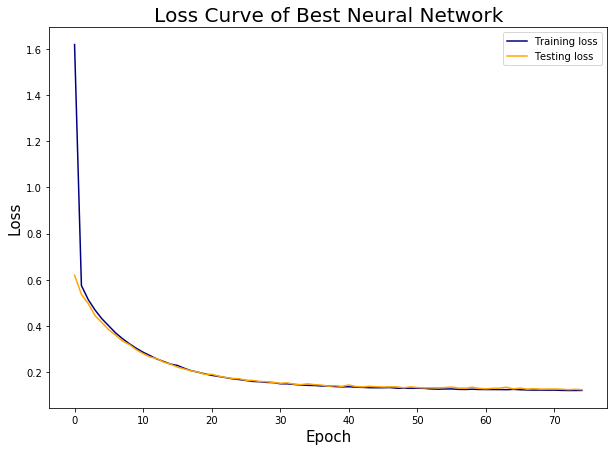

In [41]:
train_loss = final_nn_model_dict["best_history"].history["loss"]
test_loss = final_nn_model_dict["best_history"].history["val_loss"]


plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='orange')
plt.title("Loss Curve of Best Neural Network", size=20)
plt.xlabel("Epoch", size=15)
plt.ylabel("Loss", size=15)
plt.legend();

This line graph shows us how the loss of our final model changed as it ran through all 75 epochs, without utilizing the early stopping callback. There does not appear to be a lot of variation in the curves, and we have avoided significant divergence of the losses between the train and test set, though the test loss does tick up slightly at the end.

We can see from this comparison of predicted and actual serving sizes that our model has a clear tendency to underpredict servings as the real serving size increases. There could be several reasons behind why this is happening, though one clear and logical answer may be that some of those foods with larger serving sizes have larger portions of the food that are inedible. This could mean a food that has shells or pits, or something else that is counted in the total weight, but is not eaten. This is most likely where the outliers are arising from. Unfortunately, these aspects were not accounted for in this model.

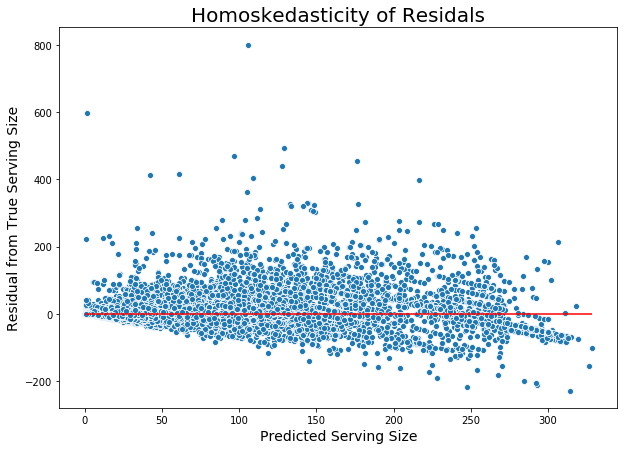

In [63]:
# finding residuals
resids = test_pred_df["y_test"] - test_pred_df["neural_net"]

# making plot of resids vs. preds
plt.figure(figsize=(10, 7))
sns.scatterplot(test_pred_df["neural_net"], resids)
plt.title("Homoskedasticity of Residals", size=20)
plt.xlabel("Predicted Serving Size", size=14)
plt.ylabel("Residual from True Serving Size", size=14)

# plotting line at 0
plt.hlines(0, 0, max(test_pred_df["neural_net"]), colors="red");

This plot shows that the residuals from the model are fairly homoscedastic, with only a few outliers. There could be several reasons behind the placement of these outliers, though one clear and logical answer may be that some of those foods with larger serving sizes have larger portions of the food that are inedible. This could mean a food that has shells or pits, or something else that is counted in the total weight, but is not eaten. This is most likely where the outliers are arising from. Unfortunately, these aspects were not accounted for in this model.

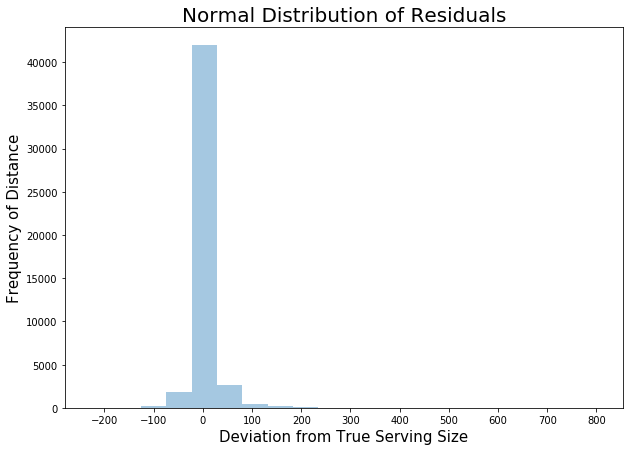

In [73]:
plt.figure(figsize=(10, 7))
sns.distplot(resids, bins=20, kde=False)
plt.title("Normal Distribution of Residuals", size=20)
plt.xlabel("Deviation from True Serving Size", size=15)
plt.ylabel("Frequency of Distance", size=15)
plt.xticks(range(-200, 801, 100));

We can see from this histogram that the residuals form a normally shaped distrubition, albeit with a long right tail. Coupled with the scatterplot above, We can conclude that we have made a well fit model with no clear trends in the errors.

## Conclusions and Recommendations

### Conclusions

Utilizing a feed forward neural network gave use the best results overall. It was able to increase the R<sup>2</sup> score above 80%, and still limit difference between the train and test sets to below 1.5%. It was also able to minimize MSE far better than the other models that were made. However, this model was still not perfect, and there are still outliers in the residuals. Unfortunately, utilizing a neural network does not give use any kind of further interpretability beyond the metrics that were tested. Unlike the linear models, we do not have clear coefficients that can be related back to specific features in terms of importance.

As discussed above, this may be influenced by factors unseen by the model, such as the percentage of the food item that is not typically eaten. In addition, this model only takes certain attributes into account, and there are many other factors that can have an impact on serving size, such as package size, sale price, or targeted demographic. Many of these factors can be proprietary information to the manufacturing company, and are unavailable to the public, making a deeper analysis difficult. This could, however, be adapted within a specific company to account for some of these features, or to be trained on a more specific set of foods products.

In the end, this model should still be fairly useful to a project team that is working to develop a new food product. If the standard nutrition facts and category can be entered, the resulting serving size should be fairly close to similar products on the market in that category, and can be useful in the development process. This way, researchers have a good idea of what their final servings size might be, and can have a head start on things like branding and marketing.

### Recommendations

One of the main recommendations for this project would be to conduct further analysis of the vectorized ingredients. Utilizing the ingredients as features did not appear to help our models in the current scope, though with more time to optimize, they may be able to improve the model further. A more complex method of cleaning and vectorizing this feature may allow it to be more effectively be incorporated into the model. As ingredients lists are always in order of largest to smallest amounts, it may be possible to use some kind of weight attribute on ingredients to show the impact of that ingredient of the food's nutrition and serving size. Further use of NLP could also be used to analyze the food descriptions or brand owners as well.

Another interesting step to take would be to perform PCA on the nutrient features. This would be able to definitively eliminate any possibility of multicolinearity in the X variables. It would also ensure that only the most valuable elements of each of the features were being effectively used to make the prediction.

Further utilization of the neural network grid search function. The project timeline and available computing power were severe limits on fully fleshing out the neural network. Of course the possibilities are truly endless, but even within the scope of layers, nodes, and regularization that were searched through here, there is most likely further optimization that could be done.

Another modeling option could be to use a support vector machine (SVM), as this may be a more fitting model for this type of data. Unfortunately, due to the large amount of data and features being used, there was once again a computing power issue preventing this type of model from being run. It may also be possible to use a decision tree-based regressor model on this data.

Overall, the computational issues in this project could possibly be overcome by utilizing cloud computing services, such as those available on Amazon Web Services, or perhaps even just using a more powerful home computer.

The last recommendation would be to continually maintain the dataset, as the USDA periodically updates the information stored in it. This could entail downloading the zip file when a new version comes out, or it could be linked to the API access port to continually update.